### Spectral Clustering

In [1]:
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from silx.io.dictdump import h5todict
from sklearn.cluster import SpectralClustering

In [2]:
from scipy import constants
eV_to_J = constants.eV

Inputs

In [3]:
nb_states = 6115
kin_file = "/home/zanardi/Workspace/AirDatabase/HDF5/QCT/Orig/O3_UMN.hdf5"
lev_file = "/home/zanardi/Codes/TC/HyperNet/database/levels/O3_UMN/O2.csv"

In [4]:
nb_b = 3
nb_qb = 1
# nb_b = 6
# nb_qb = 2
nb = nb_b + nb_qb

Databases

In [5]:
kinetics = h5todict(kin_file)

In [6]:
k = kinetics["T_10000_10000"]["Rates"]["Excit"]
k = np.tril(k, k=-1)

In [7]:
levels = pd.read_csv(lev_file)
e = (levels["E"] - np.amin(levels["E"])).values # * eV_to_J
e_d = 5.113 * eV_to_J
e_v = levels["EVib"].values
e_r = levels["ERot"].values
e_v -= e_v.min()
e_r -= e_r.min()
J = levels["jqn"].values

In [8]:
iv = np.where(levels["jqn"] == 0)[0]
e_d = np.amax(e_v[iv]) #* eV_to_J
e_d

5.1130347854413

In [28]:
e = e - e_d

Bound and quasi-bound states

In [9]:
i = np.where(e > e_d)[0][0]
i_b = np.arange(i)
i_qb = np.arange(i,nb_states)

In [10]:
def get_probmat(
  mapping
):
  mapping = (mapping - np.amin(mapping)).astype(int)
  nb_levs, nb_bins = len(mapping), np.amax(mapping)+1
  data = np.ones(nb_levs)
  indices = (np.arange(nb_levs), mapping)
  shape = (nb_levs, nb_bins)
  return sp.sparse.coo_matrix((data, indices), shape).toarray()

> Energy-based clustering

In [11]:
def energy_bin(e, e_d, nb_b, nb_qb, eps=1e-6):
  # Min/max energies
  e_min, e_max = np.amin(e), np.amax(e)
  # Energy intervals
  inter_b = np.linspace(e_min, e_d, nb_b+1)
  if (nb_qb > 0):
    inter_qb = np.linspace(e_d, e_max, nb_qb+1)[1:]
  else:
    inter_qb = np.array([])
  intervals = np.concatenate([inter_b, inter_qb])
  intervals[-1] *= 1.0+eps
  # Define mapping
  mapping = (e.reshape(-1,1) >= intervals.reshape(1,-1))
  mapping = np.sum(mapping, axis=1)
  return mapping

In [12]:
map_en = energy_bin(e, e_d, nb_b, nb_qb, eps=1e-6)
map_en_b = map_en[:i]
map_en_qb = map_en[i:]

> Spectral clustering

In [13]:
def get_s(e, k, fk=1.0, fe=1.0):
  de = np.abs(e.reshape(-1,1) - e.reshape(1,-1))
  kmin = k[k>0].min() * 1e-5
  kk = k + k.T + kmin
  s = de**fe / kk**fk
  return np.exp(-s)

def spectral_bin(e, k, i, nb=6, fk=1.0, fe=1.0):
  ei, ki = e[i], k[i][:,i]
  clust = SpectralClustering(n_clusters=nb, affinity='precomputed', random_state=0)
  mapping = clust.fit_predict(get_s(ei, ki, fk, fe))
  mapping += 1-np.amin(mapping)
  return mapping

In [14]:
# if nb_qb > 1:
#   fk, fe = 1.45, 0.94
# else:
#   fk, fe = 1.45, 1.0
# map_sp_b = spectral_bin(e, k, i_b, nb_b, fk, fe)
# map_sp_qb = spectral_bin(e, k, i_qb, nb_qb, fk=1.45, fe=1.0)
# map_sp = np.concatenate([map_sp_b, map_sp_qb+nb_b])

In [15]:
path = "/home/zanardi/Codes/TC/HyperNet/database/grouping/O3_UMN/O2/LevelsMap_MAPEQ11.csv"
map_sp = pd.read_csv(path).values[:,1]

Plot clustering

In [42]:
def plot_clust_2d(map, title, filename=None):
  plt.figure()
  for c in range(map.max()):
    i = (map == c+1)
    plt.scatter(J[i], e[i], s=2)
  plt.xlabel('$J$')
  plt.ylabel('$\epsilon_i$ [eV]')
  plt.title(title)
  plt.tight_layout()
  if filename:
    plt.savefig(filename)
  plt.show()

def plot_clust_1d(map, title):
  plt.figure()
  for c in range(map.max()):
    i = (map == c+1)
    plt.scatter(e[i]/eV_to_J, np.ones_like(e[i])*(c+1), s=2)
  plt.xlabel('$\epsilon_i$ [eV]')
  plt.ylabel('Cluster')
  plt.title(title)
  plt.show()

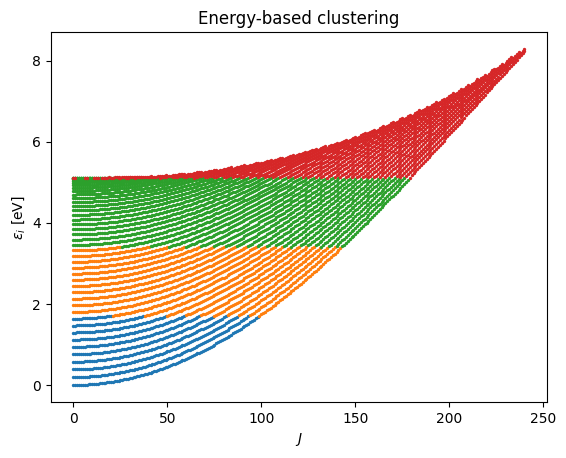

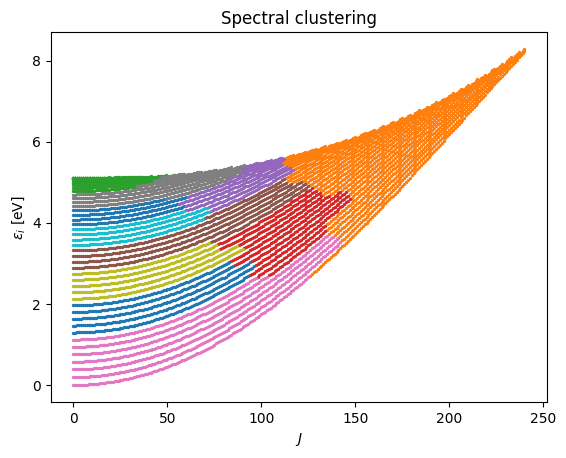

In [17]:
plot_clust_2d(map_en, title="Energy-based clustering")
plot_clust_2d(map_sp, title="Spectral clustering")

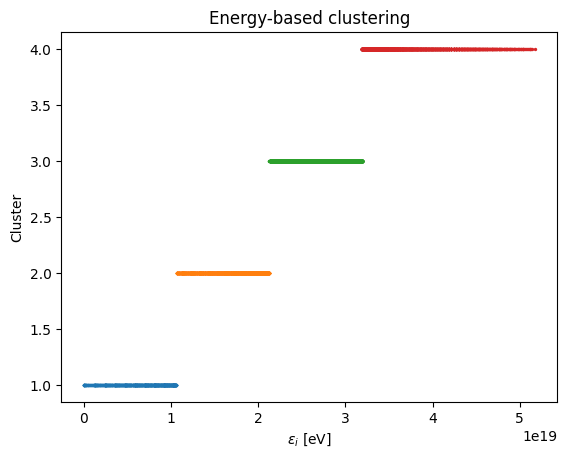

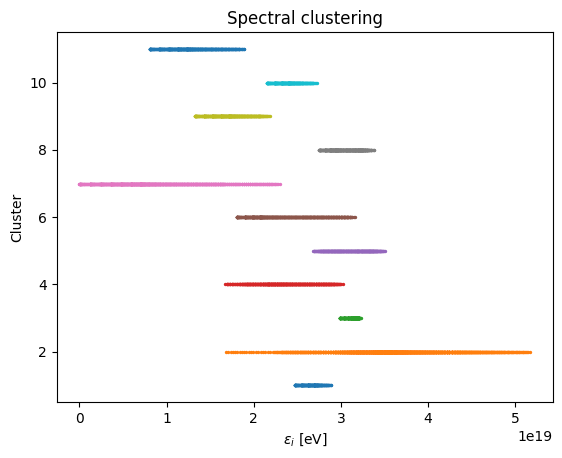

In [18]:
plot_clust_1d(map_en, title="Energy-based clustering")
plot_clust_1d(map_sp, title="Spectral clustering")

Save clustering

In [19]:
path_to_saving = f"./../testcases/RVE{nb}/"
os.makedirs(path_to_saving, exist_ok=True)
np.savetxt(
  path_to_saving + "/mapping.csv",
  np.vstack([np.arange(nb_states), map_en]).T,
  fmt='%i',
  delimiter=',',
  header='Idx,Group'
)

In [20]:
path_to_saving = f"./../testcases/ADA{nb}/"
os.makedirs(path_to_saving, exist_ok=True)
np.savetxt(
  path_to_saving + "/mapping.csv",
  np.vstack([np.arange(nb_states), map_sp]).T,
  fmt='%i',
  delimiter=',',
  header='Idx,Group'
)

In [21]:
groups = {
  1: [1,10,5],
  3: [3,8]
}
group = [2,4,6,7,9,11]

In [22]:
map = np.zeros(nb_states)
k = 1
for i in range(11):
  if i in groups:
    for j in groups[i]:
      map[map_sp==j] = k
    k += 1
  elif i in group:
    map[map_sp==i] = k
    k += 1
  else:
    continue
map = map.astype(int)+1

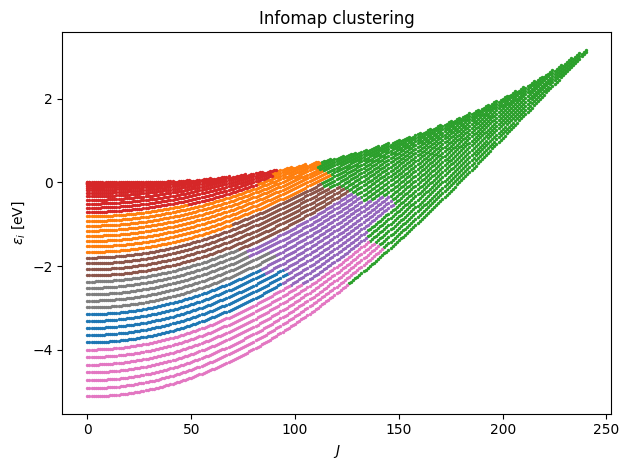

In [43]:
path_to_saving = "./../rom_cg/MAPEQ8/"
os.makedirs(path_to_saving, exist_ok=True)
plot_clust_2d(map, title="Infomap clustering", filename=path_to_saving+"/mapping.png")

In [44]:
np.savetxt(
  path_to_saving + "/mapping.csv",
  np.vstack([np.arange(nb_states), map]).T,
  fmt='%i',
  delimiter=',',
  header='Idx,Group'
)

In [46]:
map.max()

8

In [25]:

from infomap import Infomap

In [26]:
def get_mapping(k, num_trials=10):
  im = Infomap(
    flow_model='directed',
    silent=False,
    num_trials=num_trials
  )
  # Add links
  indices = np.where(k > 0)
  links = list(zip(*[*indices, k[indices]]))
  im.add_links(links)
  # Running map equation
  im.run()
  # Collect mapping
  lev_to_bins = list(zip(*list(im.multilevel_modules)))[1]
  lev_to_bins = np.array(lev_to_bins)
  lev_to_bins -= np.amin(lev_to_bins, 0)
  return lev_to_bins

In [27]:
ke = kinetics["T_10000_10000"]["Rates"].

SyntaxError: invalid syntax (1018373031.py, line 1)

In [ ]:
kinetics["T_10000_10000"]["Rates"].keys()

In [ ]:
import numpy as np
import joblib as jl

from infomap import Infomap

from .basic import Basic
from hypernet import utils
from hypernet import backend as bkd
from ..kinetics.one_temp.reaction.global_data import PROCESS_IDX
from hypernet.config import get_config
_CFG = get_config()


class MapEq(Basic):

  # Initialization
  # ===================================
  def __init__(
    self,
    T,
    num_trials=1,
    hierarchical=False,
    specie_thermos=None,
    save_dir="./",
    prob_mat=False,
    plotting=False,
    *args,
    **kwargs
  ):
    super(MapEq, self).__init__(
      nb_bins=None,
      specie_thermos=specie_thermos,
      save_dir=save_dir,
      prob_mat=prob_mat,
      plotting=plotting,
      *args,
      **kwargs
    )
    # Acronym
    self.acronym = "MAPEQ"
    # Kinetics
    self.use_kin = True
    self.scale = 1e15
    self.sides = ["reactants", "products"]
    # Temperature
    self.T = np.array(T).reshape(1,1)
    # Infomap attributes
    self.num_trials = num_trials
    self.hierarchical = hierarchical

  # Class methods
  # ===================================
  # Binning
  # -----------------------------------
  def group(self, kin, *args, **kwargs):
    # Kinetics
    self.kin = kin
    self.kin._update_thermochem(self.T)
    self.indices = self.specie_thermos[self.name].specie.comp_indices
    # Weights
    w = self._compute_weight()
    # Binning
    lev_to_bins = self._get_mapping(w, self.indices)
    # Post-processing
    for lev_to_bin in lev_to_bins.T:
      self.lev_to_bin = lev_to_bin
      self.nb_bins = np.amax(lev_to_bin) + 1
      self._postprocessing()

  def _get_mapping(self, w, indices):
    if self.hierarchical:
      return self._get_mapping_multimod(w, indices)
    else:
      return self._get_mapping_singlemod(w, indices)

  def _get_mapping_multimod(self, w, indices):
    # Zero-module binning - Computing
    l0_lev_to_bin = self._get_mapping_singlemod(w, indices)[:,0]
    l0_nb_bins = np.amax(l0_lev_to_bin) + 1
    # Zero-module binning - Assembling
    l0_bins = []
    for b in range(l0_nb_bins):
      i = np.where(l0_lev_to_bin == b)[0]
      wi = w[i][:,i]
      l0_bins.append((wi/np.sum(wi), i))
    # First-module binning - Computing
    l1_lev_to_bins = jl.Parallel(n_jobs=_CFG.cpu_threads)(
      jl.delayed(self._get_mapping_singlemod)(w=bin[0]) for bin in l0_bins
    )
    # First-module binning - Assembling
    l1_lev_to_bin = np.zeros_like(l0_lev_to_bin)
    l1_nb_bins = 0
    for (b, bin) in enumerate(l0_bins):
      # Mapping
      lev_to_bin = l1_lev_to_bins[b][:,0]
      l1_lev_to_bin[bin[1]] = lev_to_bin + l1_nb_bins
      # Number of bins
      nb_bins = np.amax(lev_to_bin) + 1
      l1_nb_bins += nb_bins
    l1_lev_to_bin = l1_lev_to_bin.astype(int)
    # Multi-module binning
    lev_to_bins = np.vstack([l0_lev_to_bin,l1_lev_to_bin]).T
    return lev_to_bins

  def _get_mapping_singlemod(self, w, indices=None):
    # Running map equation
    im = Infomap(
      flow_model='directed',
      silent=True,
      num_trials=self.num_trials
    )
    im.add_links(self._create_links(w))
    im.run()
    # Collect mapping
    lev_to_bins = list(zip(*list(im.multilevel_modules)))[1]
    lev_to_bins = np.array(lev_to_bins)
    if (indices is not None):
      indices -= (np.amax(indices)+1 - len(lev_to_bins))
      lev_to_bins = lev_to_bins[indices]
    lev_to_bins = lev_to_bins - np.amin(lev_to_bins, 0)
    return lev_to_bins
  
  def _create_links(self, w):
    indices = np.where(w > 0)
    links = list(zip(*[*indices, w[indices]]))
    return links

  # Weight matrix
  # -----------------------------------
  def _compute_weight(self):
    nc = self.kin.mixture.nb_comp
    w = np.zeros((nc,nc))
    for reaction in self.kin.reactions:
      for direction in ("fwd", "bwd"):
        self._update_weight_reac(w, reaction, direction)
    return w * self.scale

  def _update_weight_reac(self, w, reaction, direction="fwd"):
    # Get reaction rates
    sides = self.sides.copy()
    if (direction == "fwd"):
      k = bkd.to_numpy(reaction.fwd.k).squeeze()
    else:
      k = bkd.to_numpy(reaction.bwd.k).squeeze().T
      sides.reverse()
    # Get species indices
    if (reaction.param["process"] == PROCESS_IDX["Dh"]):
      indices = self._get_indices_Dh(reaction, sides, direction)
    elif (reaction.param["process"] in (PROCESS_IDX[k] for k in ("EXh","EXC"))):
      indices = self._get_indices_EX(reaction, sides)
      indices.reverse()
    else:
      utils.raise_err(NotImplementedError)
    # Update weight matrix
    indices = tuple([
      i.astype(int).reshape(-1) for i in np.meshgrid(*indices)
    ])
    w[indices] += k.reshape(-1)

  def _get_indices_Dh(self, reaction, sides, direction):
    indices = []
    for specie in reaction.param[sides[0]]:
      st = self.specie_thermos[specie[1]]
      c1 = ((st.specie.lev["nb"] >  1) and (direction == "fwd"))
      c2 = ((st.specie.lev["nb"] == 1) and (direction == "bwd"))
      if (c1 or c2):
        indices.append(st.specie.comp_indices)
        break
    for specie in reaction.param[sides[1]]:
      st = self.specie_thermos[specie[1]]
      c1 = ((st.specie.lev["nb"] == 1) and (direction == "fwd"))
      c2 = ((st.specie.lev["nb"] >  1) and (direction == "bwd"))
      if (c1 or c2):
        indices.append(st.specie.comp_indices)
        break
    return indices

  def _get_indices_EX(self, reaction, sides):
    indices = []
    for side in sides:
      for specie in reaction.param[side]:
        st = self.specie_thermos[specie[1]]
        if (st.specie.lev["nb"] > 1):
          indices.append(st.specie.comp_indices)
          break
    return indices
